In [1]:
# %%
# =======================================================
# CELL 1: IMPORTS
# =======================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import (
    Input, Conv2D, GlobalAveragePooling2D, Dense, Multiply, Resizing,
    BatchNormalization, Dropout, Activation, Concatenate
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import tensorflow.keras.applications.efficientnet as effnet_preprocess
import tensorflow.keras.applications.resnet as resnet_preprocess

import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score, confusion_matrix
)
from tqdm import tqdm
import albumentations as A

# Imports for Mask Generation (Cell 3)
import torch
import torch.nn as nn
from torch.distributions import Normal, Independent
from torch.distributions.kl import kl_divergence as KLD
from torch.nn.functional import softplus
import json
import csv
import time
import hashlib

2025-11-12 15:46:41.315336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762962401.567539      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762962401.636788      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# %%
# =======================================================
# CELL 2: CONFIGURATION
# =======================================================
class Config:
    # 1. Paths
    DATA_ROOT = "/kaggle/input/chest-xray-pneumonia/chest_xray"
    MASK_ROOT = "/kaggle/working/chest_xray_segmented_v1"
    CHECKPOINT_DIR = "/kaggle/working/checkpoints_all_pipelines/"
    AVAILABLE_CHECKPOINT_DIR = "/kaggle/working/checkpoints_all_pipelines/"
    VAE_WEIGHTS_PATH = "/kaggle/input/lungvae/lungVAE.pt"

    # 2. Data Params
    IMG_SIZE = (224, 224)
    INPUT_SHAPE = (*IMG_SIZE, 3)
    # Kích thước gốc của mask từ model LungVAE
    MASK_H_ORIG, MASK_W_ORIG = 640, 512

    # 3. Training Params
    BATCH_SIZE = 32
    AUTOTUNE = tf.data.AUTOTUNE
    
    # 4. Model Params
    # Định nghĩa kích thước feature map (H, W) cho các model
    # Cần kiểm tra model.summary() để lấy kích thước này
    # ResNet50 (conv5_block3_out): (7, 7)
    # EfficientNetB0 (top_conv): (7, 7)
    RESNET_FM_SIZE = (7, 7)
    EFFNET_FM_SIZE = (7, 7)

    # 5. Class Mapping
    CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
    CLASS_INDICES = {"NORMAL": 0, "PNEUMONIA": 1}

    # 6. Pipeline Names
    P1 = "P1_ResNet50_Baseline"
    P2 = "P2_EffNetB0_Baseline"
    P3 = "P3_ResNet50_Attention_Concat"
    P4 = "P4_EffNetB0_Attention_Concat"

    
# --- Khởi tạo các thư mục ---
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(Config.MASK_ROOT, exist_ok=True)
os.makedirs(os.path.join(Config.MASK_ROOT, "META"), exist_ok=True)

print("Cấu hình hoàn tất. Các thư mục đã sẵn sàng.")

Cấu hình hoàn tất. Các thư mục đã sẵn sàng.


In [3]:
# %%
# =======================================================
# CELL 3: MASK GENERATION (PYTORCH)
# (Đã tối ưu: chỉ chạy trên 'train' và 'test' nếu có, không chạy 'val')
# =======================================================

# --- Dán class uVAE và convBlock (đã thu gọn) ---
class convBlock(nn.Module):
    def __init__(self, inCh, nhid, nOp, pool=True, ker=3,padding=1,pooling=2):
        super(convBlock,self).__init__()
        self.enc1 = nn.Conv2d(inCh,nhid,kernel_size=ker,padding=1)
        self.enc2 = nn.Conv2d(nhid,nOp,kernel_size=ker,padding=1)
        self.bn = nn.BatchNorm2d(inCh)
        if pool: self.scale = nn.AvgPool2d(kernel_size=pooling)
        else: self.scale = nn.Upsample(scale_factor=pooling)
        self.pool = pool; self.act = nn.ReLU()
    def forward(self,x):
        x = self.scale(x); x = self.bn(x)
        x = self.act(self.enc1(x)); x = self.act(self.enc2(x))
        return x

class uVAE(nn.Module):
    def __init__(self, nlatent,unet=False, nhid=8, ker=3, inCh=1,h=640,w=512):
        super(uVAE, self).__init__()
        self.latent_space = nlatent; self.unet = unet; self.h = h; self.w = w
        if not self.unet:
            self.enc11 = nn.Conv2d(inCh,nhid,kernel_size=ker,padding=1)
            self.enc12 = nn.Conv2d(nhid,nhid,kernel_size=ker,padding=1)
            self.enc2 = convBlock(nhid,2*nhid,2*nhid,pool=True)
            self.enc3 = convBlock(2*nhid,4*nhid,4*nhid,pool=True)
            self.enc4 = convBlock(4*nhid,8*nhid,8*nhid,pool=True)
            self.enc5 = convBlock(8*nhid,16*nhid,16*nhid,pool=True)
            self.bot11 = nn.Conv1d(16*nhid,1,kernel_size=1)
            self.bot12 = nn.Conv1d(int((h/16)*(w/16)),2*nlatent,kernel_size=1)
            self.bot21 = nn.Conv1d(nlatent,int((h/64)*(w/64)),kernel_size=1)
            self.bot22 = nn.Conv1d(1,nhid,kernel_size=1)
            self.bot23 = nn.Conv1d(nhid,4*nhid,kernel_size=1)
            self.bot24 = nn.Conv1d(4*nhid,16*nhid,kernel_size=1)
        self.uEnc11 = nn.Conv2d(inCh,nhid,kernel_size=ker,padding=1)
        self.uEnc12 = nn.Conv2d(nhid,nhid,kernel_size=ker,padding=1)
        self.uEnc2 = convBlock(nhid,2*nhid,2*nhid,pool=True,pooling=4)
        self.uEnc3 = convBlock(2*nhid,4*nhid,4*nhid,pool=True,pooling=4)
        self.uEnc4 = convBlock(4*nhid,8*nhid,8*nhid,pool=True)
        self.uEnc5 = convBlock(8*nhid,16*nhid,16*nhid,pool=True)
        if not self.unet: self.dec5 = convBlock(32*nhid,8*nhid,8*nhid,pool=False)
        else: self.dec5 = convBlock(16*nhid,8*nhid,8*nhid,pool=False)
        self.dec4 = convBlock(16*nhid,4*nhid,4*nhid,pool=False)
        self.dec3 = convBlock(8*nhid,2*nhid,2*nhid,pool=False,pooling=4)
        self.dec2 = convBlock(4*nhid,nhid,nhid,pool=False,pooling=4)
        self.dec11 = nn.Conv2d(2*nhid,nhid,kernel_size=ker,padding=1)
        self.dec12 = nn.Conv2d(nhid,inCh,kernel_size=ker,padding=1)
        self.act = nn.ReLU()
        self.mu_0 = torch.zeros((1,nlatent)); self.sigma_0 = torch.ones((1,nlatent))
    def vae_encoder(self,x):
        x = self.act(self.enc11(x)); x = self.act(self.enc12(x))
        x = self.enc2(x); x = self.enc3(x); x = self.enc4(x); x = self.enc5(x)
        z = self.act(self.bot11(x.view(x.shape[0],x.shape[1],-1)))
        z = self.bot12(z.permute(0,2,1)); return z.squeeze(-1)
    def unet_encoder(self,x_in):
        x = []; x.append(self.act(self.uEnc12(self.act(self.uEnc11(x_in)))))
        x.append(self.uEnc2(x[-1])); x.append(self.uEnc3(x[-1]))
        x.append(self.uEnc4(x[-1])); x.append(self.uEnc5(x[-1]))
        return x
    def decoder(self,x_enc,z=None):
        if not self.unet:
            x = self.act(self.bot21(z.unsqueeze(2))); x = self.act(self.bot22(x.permute(0,2,1)))
            x = self.act(self.bot23(x)); x = self.act(self.bot24(x))
            x = x.view(x.shape[0],x.shape[1],int(self.h/64),int(self.w/64))
            x = torch.cat((x,x_enc[-1]),dim=1); x = self.dec5(x)
        else: x = self.dec5(x_enc[-1])
        x = torch.cat((x,x_enc[-2]),dim=1); x = self.dec4(x)
        x = torch.cat((x,x_enc[-3]),dim=1); x = self.dec3(x)
        x = torch.cat((x,x_enc[-4]),dim=1); x = self.dec2(x)
        x = torch.cat((x,x_enc[-5]),dim=1); x = self.act(self.dec11(x)); x = self.dec12(x)
        return x
    def forward(self, x):
        kl = torch.zeros(1, device=x.device); z = 0.
        x_enc = self.unet_encoder(x)
        if not self.unet:
            emb = self.vae_encoder(x); mu, log_var = torch.chunk(emb, 2, dim=1)
            log_var = softplus(log_var); sigma = torch.exp(log_var / 2)
            posterior = Independent(Normal(loc=mu,scale=sigma),1)
            z = posterior.rsample()
            prior = Independent(Normal(loc=self.mu_0.to(x.device),scale=self.sigma_0.to(x.device)),1)
            kl = KLD(posterior,prior).sum()
        xHat = self.decoder(x_enc,z); return kl, xHat

# --- Dán các hàm utils (đã thu gọn) ---
def is_image_file(p): return p.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))
def ensure_dirs(base, split, label):
    base2 = os.path.join(base, split, label, "mask_soft")
    os.makedirs(base2, exist_ok=True); return base2
def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: raise ValueError(f"Cannot read: {path}")
    return img
def preprocess_resize(img_np, H, W, device):
    rs = cv2.resize(img_np, (W, H), interpolation=cv2.INTER_AREA)
    x  = torch.from_numpy(rs.astype(np.float32)/255.0)[None, None, ...]
    return x.to(device)
def infer_hparams_from_state_dict(sd):
    nhid = sd["uEnc11.weight"].shape[0] if "uEnc11.weight" in sd else 8
    has_vae = ("bot21.weight" in sd) or ("bot12.weight" in sd); unet_flag = not has_vae
    nlatent = 16
    if "bot21.weight" in sd: nlatent = sd["bot21.weight"].shape[1]
    h, w = 640, 512
    if "bot12.weight" in sd:
        in_c = sd["bot12.weight"].shape[1]; candidates = []
        for H in [512, 576, 600, 640, 672, 704, 720, 736, 768, 800, 832, 896, 960, 1024]:
            for W in [384, 400, 448, 480, 512, 544, 576, 600, 640, 672, 704, 720, 736, 768, 800, 896, 960, 1024]:
                if (H % 16 == 0) and (W % 16 == 0) and (H//16)*(W//16) == in_c: candidates.append((H,W))
        if (640,512) in candidates: h,w = 640,512
        elif candidates: h,w = candidates[0]
    return nlatent, nhid, h, w, unet_flag

def run_mask_generation():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[Mask Gen] Using Device: {DEVICE}")

    # 1. Load Model
    obj = torch.load(Config.VAE_WEIGHTS_PATH, map_location="cpu")
    sd = obj["state_dict"] if isinstance(obj, dict) and "state_dict" in obj else obj
    nlatent, nhid, Himg, Wimg, unet_flag = infer_hparams_from_state_dict(sd)
    assert (Himg, Wimg) == (Config.MASK_H_ORIG, Config.MASK_W_ORIG), "Kích thước mask VAE không khớp!"

    print(f"[Mask Gen] Inferred: nlatent={nlatent}, nhid={nhid}, H×W={Himg}×{Wimg}, unet={unet_flag}")
    model = uVAE(nlatent=nlatent, unet=unet_flag, nhid=nhid, inCh=1, h=Himg, w=Wimg)
    model.load_state_dict(sd, strict=False)
    model.to(DEVICE).eval()

    # 2. Chuẩn bị CSV
    csv_path = os.path.join(Config.MASK_ROOT, "META", "index.csv")
    csv_cols = ["split","label","orig_path","mask_soft_path", "H","W"]
    
    # 3. Hàm dự đoán
    @torch.no_grad()
    def predict_soft_mask(img_np):
        x = preprocess_resize(img_np, Himg, Wimg, DEVICE)
        kl, xHat = model(x)
        if (xHat.min() < 0.0) or (xHat.max() > 1.0):
            xHat = torch.sigmoid(xHat)
        prob = xHat.squeeze(0).squeeze(0).detach().cpu().numpy()
        return prob

    # 4. Loop và Tạo mask
    print("[Mask Gen] Bắt đầu tạo mask...")
    # TỐI ƯU: Chỉ chạy trên 'train' và 'test' (nếu tồn tại)
    splits_to_process = [d for d in ["train","test"] if os.path.isdir(os.path.join(Config.DATA_ROOT,d))]
    
    with open(csv_path, "w", newline="") as csv_f:
        csv_w = csv.DictWriter(csv_f, fieldnames=csv_cols)
        csv_w.writeheader()
        
        for split in splits_to_process:
            for label_name, label_idx in Config.CLASS_INDICES.items():
                in_dir = os.path.join(Config.DATA_ROOT, split, label_name)
                if not os.path.isdir(in_dir): continue

                base2_mask_soft = ensure_dirs(Config.MASK_ROOT, split, label_name) 
                
                # Dùng glob để tìm file ảnh, linh hoạt hơn
                files = glob.glob(os.path.join(in_dir, "*.jpeg")) + \
                        glob.glob(os.path.join(in_dir, "*.jpg")) + \
                        glob.glob(os.path.join(in_dir, "*.png"))
                
                print(f"[Mask Gen] {split}/{label_name}: {len(files)} files")

                for src_path in tqdm(files):
                    try:
                        img = read_gray(src_path); H0, W0 = img.shape[:2]
                        prob_small = predict_soft_mask(img)
                        
                        fname = os.path.basename(src_path)
                        name = os.path.splitext(fname)[0]
                        
                        out_mask_soft = os.path.join(base2_mask_soft, f"{name}_mask_soft.npy")
                        np.save(out_mask_soft, prob_small.astype(np.float16))

                        row = {
                            "split": split, "label": label_name, "orig_path": src_path,
                            "mask_soft_path": os.path.relpath(out_mask_soft, Config.MASK_ROOT),
                            "H": H0, "W": W0
                        }
                        csv_w.writerow(row)
                    except Exception as e:
                        print(f"[Mask Gen] Lỗi khi xử lý file {src_path}: {e}")

    print("[Mask Gen] Hoàn tất tạo và lưu trữ soft masks tại:", Config.MASK_ROOT)

# --- CHẠY ---
# Kiểm tra xem mask đã được tạo chưa
mask_index_file = os.path.join(Config.MASK_ROOT, "META", "index.csv")
if not os.path.exists(mask_index_file):
    print("Chưa tìm thấy Mask. Bắt đầu chạy 'run_mask_generation()'...")
    run_mask_generation()
else:
    print(f"✅ [TÌM THẤY] Dữ liệu Mask tại: {Config.MASK_ROOT}. Bỏ qua bước tạo mask.")

Chưa tìm thấy Mask. Bắt đầu chạy 'run_mask_generation()'...
[Mask Gen] Using Device: cuda
[Mask Gen] Inferred: nlatent=8, nhid=16, H×W=640×512, unet=False
[Mask Gen] Bắt đầu tạo mask...
[Mask Gen] train/NORMAL: 1341 files


100%|██████████| 1341/1341 [01:11<00:00, 18.72it/s]


[Mask Gen] train/PNEUMONIA: 3875 files


100%|██████████| 3875/3875 [02:23<00:00, 26.96it/s]


[Mask Gen] test/NORMAL: 234 files


100%|██████████| 234/234 [00:10<00:00, 22.03it/s]


[Mask Gen] test/PNEUMONIA: 390 files


100%|██████████| 390/390 [00:14<00:00, 26.90it/s]

[Mask Gen] Hoàn tất tạo và lưu trữ soft masks tại: /kaggle/working/chest_xray_segmented_v1


In [4]:
# %%
# =======================================================
# CELL 4: DATA PREPARATION (Tạo DataFrames)
# =======================================================

def create_dataframes(data_root):
    # --- Train/Validation ---
    train_data_path = os.path.join(data_root, "train")
    
    # Dùng glob để tìm ảnh, tránh các file ẩn
    normal_files = glob.glob(os.path.join(train_data_path, 'NORMAL', '*.jpeg'))
    pneumonia_files = glob.glob(os.path.join(train_data_path, 'PNEUMONIA', '*.jpeg'))

    all_filepaths = normal_files + pneumonia_files
    all_labels = ['NORMAL'] * len(normal_files) + ['PNEUMONIA'] * len(pneumonia_files)

    X_train, X_val, y_train, y_val = train_test_split(
        all_filepaths,
        all_labels,
        test_size=0.2,
        random_state=42,
        stratify=all_labels
    )

    train_df = pd.DataFrame({'filepath': X_train, 'label': y_train})
    val_df = pd.DataFrame({'filepath': X_val, 'label': y_val})

    # --- Test ---
    test_data_path = os.path.join(data_root, "test")
    test_normal_files = glob.glob(os.path.join(test_data_path, 'NORMAL', '*.jpeg'))
    test_pneumonia_files = glob.glob(os.path.join(test_data_path, 'PNEUMONIA', '*.jpeg'))

    test_filepaths = test_normal_files + test_pneumonia_files
    test_labels = ['NORMAL'] * len(test_normal_files) + ['PNEUMONIA'] * len(test_pneumonia_files)
    
    test_df = pd.DataFrame({'filepath': test_filepaths, 'label': test_labels})

    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df, val_df, test_df

# --- CHẠY ---
train_df, val_df, test_df = create_dataframes(Config.DATA_ROOT)
print("\nPhân bổ tập Train:")
print(train_df['label'].value_counts())
print("\nPhân bổ tập Val:")
print(val_df['label'].value_counts())
print("\nPhân bổ tập Test:")
print(test_df['label'].value_counts())

Train: 4172, Val: 1044, Test: 624

Phân bổ tập Train:
label
PNEUMONIA    3099
NORMAL       1073
Name: count, dtype: int64

Phân bổ tập Val:
label
PNEUMONIA    776
NORMAL       268
Name: count, dtype: int64

Phân bổ tập Test:
label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


In [5]:
# %%
# =======================================================
# CELL 5: DATA LOADERS (Generator chuẩn hóa)
# (ĐÃ SỬA LỖI: Resize ảnh gốc về kích thước mask (640x512)
#  TRƯỚC KHI đưa vào albumentations)
# =======================================================

# --- 1. Định nghĩa Augmentations (dùng Albumentations) ---
# TỐI ƯU: Dùng 1 bộ augmentation duy nhất cho cả 4 pipeline
# 'mask' sẽ được tự động transform cùng 'image'
def get_train_transforms(img_size):
    return A.Compose([
        A.Resize(img_size[0], img_size[1], interpolation=cv2.INTER_LINEAR),
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    ], p=1.0)

def get_val_test_transforms(img_size):
    return A.Compose([
        A.Resize(img_size[0], img_size[1], interpolation=cv2.INTER_LINEAR),
    ], p=1.0)


# --- 2. Class Generator Tổng Quát ---
class PneumoniaDataGenerator(Sequence):
    def __init__(self, df, mask_root, batch_size, target_size, 
                 mode='baseline', 
                 preprocessing_function=None,
                 augmentation=None, 
                 shuffle=True, 
                 mask_target_size=None):
        
        self.df = df.copy()
        self.mask_root = mask_root
        self.batch_size = batch_size
        self.target_size = target_size
        self.mode = mode # 'baseline' or 'attention'
        self.preprocessing_function = preprocessing_function
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.mask_target_size = mask_target_size # (H, W) của feature map
        
        if self.mode not in ['baseline', 'attention']:
            raise ValueError("Mode phải là 'baseline' hoặc 'attention'")
        
        if self.mode == 'attention' and self.mask_target_size is None:
            raise ValueError("Mode 'attention' cần 'mask_target_size'")
            
        self.labels = self.df['label'].map(Config.CLASS_INDICES).values
        self.filepaths = self.df['filepath'].values
        
        self.indices = np.arange(len(self.filepaths))
        self.on_epoch_end()

    def __len__(self):
        # TỐI ƯU: Dùng np.ceil để xử lý batch cuối cùng
        return int(np.ceil(len(self.filepaths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.filepaths))
        current_batch_size = end_idx - start_idx
        
        batch_indices = self.indices[start_idx:end_idx]

        # Khởi tạo batch
        if self.mode == 'baseline':
            X_img = np.empty((current_batch_size, *self.target_size, 3), dtype=np.float32)
        else: # 'attention'
            X_img = np.empty((current_batch_size, *self.target_size, 3), dtype=np.float32)
            X_mask = np.empty((current_batch_size, *self.mask_target_size, 1), dtype=np.float32)

        y = np.empty((current_batch_size), dtype=int)

        for i, idx in enumerate(batch_indices):
            img_path = self.filepaths[idx]
            
            # 1. Tải ảnh
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 2. Tải mask (nếu cần) và áp dụng augmentation
            if self.mode == 'baseline':
                if self.augmentation:
                    augmented = self.augmentation(image=img)
                    X_img[i,] = augmented['image']
                else:
                    X_img[i,] = img # Sẽ được resize bởi augmentation
            
            else: # 'attention'
                mask = self._load_mask(img_path) # Shape (640, 512)
                
                # ======================= SỬA LỖI =======================
                # Resize ảnh (img) về kích thước của mask (640x512)
                # TRƯỚC KHI đưa vào Albumentations.
                img = cv2.resize(
                    img, 
                    (Config.MASK_W_ORIG, Config.MASK_H_ORIG), # (W, H) cho cv2
                    interpolation=cv2.INTER_LINEAR
                ) # Shape (640, 512, 3)
                # =======================================================
                
                if self.augmentation:
                    # Giờ img (640, 512) và mask (640, 512) đã khớp H/W
                    augmented = self.augmentation(image=img, mask=mask)
                    X_img[i,] = augmented['image']
                    
                    # TỐI ƯU: Resize mask về target_size (7x7) 1 lần duy nhất
                    mask_resized = cv2.resize(
                        augmented['mask'], 
                        self.mask_target_size, 
                        interpolation=cv2.INTER_LINEAR
                    )
                    X_mask[i,] = np.expand_dims(mask_resized, axis=-1)
                
                else:
                    # (Dành cho val/test)
                    augmented = self.augmentation(image=img, mask=mask)
                    X_img[i,] = augmented['image']
                    mask_resized = cv2.resize(
                        augmented['mask'], 
                        self.mask_target_size, 
                        interpolation=cv2.INTER_LINEAR
                    )
                    X_mask[i,] = np.expand_dims(mask_resized, axis=-1)

            y[i] = self.labels[idx]

        # 3. Áp dụng preprocessing (ResNet/EffNet)
        if self.preprocessing_function:
            X_img = self.preprocessing_function(X_img)
        else:
            X_img = X_img / 255.0 # Mặc định
            
        # 4. Trả về đúng format
        if self.mode == 'baseline':
            return X_img, y
        else:
            return {'image_input': X_img, 'mask_input': X_mask}, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def get_true_labels(self):
        return self.labels

    def _load_mask(self, img_path):
        # Tái tạo đường dẫn mask từ đường dẫn ảnh
        parts = img_path.split(os.path.sep)
        split, label_name, fname = parts[-3], parts[-2], parts[-1]
        base_name = os.path.splitext(fname)[0]
        mask_name = f"{base_name}_mask_soft.npy"
        mask_path = os.path.join(self.mask_root, split, label_name, "mask_soft", mask_name)
        
        if not os.path.exists(mask_path):
            # TỐI ƯU: Ném lỗi thay vì dùng fallback
            raise FileNotFoundError(f"Không tìm thấy mask: {mask_path}. Hãy chạy lại CELL 3.")
        
        # Tải mask (float16) và chuyển sang float32
        return np.load(mask_path).astype(np.float32)


# --- 3. Tạo Augmentations ---
train_aug = get_train_transforms(Config.IMG_SIZE)
val_test_aug = get_val_test_transforms(Config.IMG_SIZE)

# --- 4. Tạo Generators cho cả 4 Pipeline ---

# P1: ResNet Baseline
train_gen_p1 = PneumoniaDataGenerator(
    train_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='baseline',
    preprocessing_function=resnet_preprocess.preprocess_input,
    augmentation=train_aug,
    shuffle=True
)
val_gen_p1 = PneumoniaDataGenerator(
    val_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='baseline',
    preprocessing_function=resnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False
)
test_gen_p1 = PneumoniaDataGenerator(
    test_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='baseline',
    preprocessing_function=resnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False
)

# P2: EfficientNet Baseline
train_gen_p2 = PneumoniaDataGenerator(
    train_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='baseline',
    preprocessing_function=effnet_preprocess.preprocess_input,
    augmentation=train_aug,
    shuffle=True
)
val_gen_p2 = PneumoniaDataGenerator(
    val_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='baseline',
    preprocessing_function=effnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False
)
test_gen_p2 = PneumoniaDataGenerator(
    test_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='baseline',
    preprocessing_function=effnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False
)

# P3: ResNet + Attention (Concat)
train_gen_p3 = PneumoniaDataGenerator(
    train_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='attention',
    preprocessing_function=resnet_preprocess.preprocess_input,
    augmentation=train_aug,
    shuffle=True,
    mask_target_size=Config.RESNET_FM_SIZE # (7, 7)
)
val_gen_p3 = PneumoniaDataGenerator(
    val_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='attention',
    preprocessing_function=resnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False,
    mask_target_size=Config.RESNET_FM_SIZE
)
test_gen_p3 = PneumoniaDataGenerator(
    test_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='attention',
    preprocessing_function=resnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False,
    mask_target_size=Config.RESNET_FM_SIZE
)

# P4: EfficientNet + Attention (Concat)
train_gen_p4 = PneumoniaDataGenerator(
    train_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='attention',
    preprocessing_function=effnet_preprocess.preprocess_input,
    augmentation=train_aug,
    shuffle=True,
    mask_target_size=Config.EFFNET_FM_SIZE # (7, 7)
)
val_gen_p4 = PneumoniaDataGenerator(
    val_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='attention',
    preprocessing_function=effnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False,
    mask_target_size=Config.EFFNET_FM_SIZE
)
test_gen_p4 = PneumoniaDataGenerator(
    test_df, Config.MASK_ROOT, Config.BATCH_SIZE, Config.IMG_SIZE,
    mode='attention',
    preprocessing_function=effnet_preprocess.preprocess_input,
    augmentation=val_test_aug,
    shuffle=False,
    mask_target_size=Config.EFFNET_FM_SIZE
)

print("Đã tạo 12 (4x3) Data Generators (Đã sửa lỗi Albumentations).")

Đã tạo 12 (4x3) Data Generators (Đã sửa lỗi Albumentations).


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
# %%
# =======================================================
# CELL 6: MODEL BUILDING FACTORY (Module hóa)
# (ĐÃ CẬP NHẬT: Thêm 'name' cho các layer để hỗ trợ Grad-CAM)
# =======================================================

def build_common_head(input_tensor):
    """Đầu phân loại chung."""
    # Đặt tên 'gap' cho layer GlobalAveragePooling2D
    x = GlobalAveragePooling2D(name='gap')(input_tensor)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    return output

def build_pipeline(
    model_name: str, 
    attention_mode: str = None, 
    input_shape: tuple = Config.INPUT_SHAPE,
    mask_input_shape: tuple = None
):
    """
    Hàm factory để xây dựng 1 trong 4 pipeline.
    model_name: 'resnet50' hoặc 'efficientnetb0'
    attention_mode: None (baseline) hoặc 'concat'
    """
    
    # 1. Chọn Base Model và Feature Layer
    if model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        feature_layer_name = 'conv5_block3_out' # (None, 7, 7, 2048)
    elif model_name == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        feature_layer_name = 'top_conv' # (None, 7, 7, 1280)
    else:
        raise ValueError("Model name không được hỗ trợ.")
        
    base_model.trainable = False
    
    # 2. Xây dựng model
    image_input = Input(shape=input_shape, name='image_input')
    
    # Trích xuất feature map
    # Đặt tên cho model feature_extractor để Grad-CAM có thể tìm thấy
    feature_extractor = Model(
        inputs=base_model.input, 
        outputs=base_model.get_layer(feature_layer_name).output,
        name=f"{model_name}_feature_extractor" # <-- TÊN QUAN TRỌNG
    )
    feature_map = feature_extractor(image_input)

    # 3. Quyết định pipeline
    if attention_mode is None:
        # --- PIPELINE BASELINE (P1, P2) ---
        outputs = build_common_head(feature_map)
        model = Model(inputs=image_input, outputs=outputs)
        
    elif attention_mode == 'concat':
        # --- PIPELINE ATTENTION (P3, P4) ---
        if mask_input_shape is None:
            raise ValueError("'concat' mode yêu cầu 'mask_input_shape'")
        
        mask_input = Input(shape=mask_input_shape, name='mask_input')
        
        # Đặt tên 'concat_features' cho layer Concatenate
        combined_features = Concatenate(axis=-1, name='concat_features')( # <-- TÊN QUAN TRỌNG
            [feature_map, mask_input]
        )
        
        outputs = build_common_head(combined_features)
        model = Model(inputs=[image_input, mask_input], outputs=outputs)
        
    else:
        raise ValueError("Attention mode không được hỗ trợ.")

    return model, base_model

# --- Xây dựng 4 models ---
print("Xây dựng 4 models...")
# (Các lệnh build model giữ nguyên)
model_p1, base_model_p1 = build_pipeline(model_name='resnet50', attention_mode=None)
model_p2, base_model_p2 = build_pipeline(model_name='efficientnetb0', attention_mode=None)
model_p3, base_model_p3 = build_pipeline(
    model_name='resnet50', 
    attention_mode='concat',
    mask_input_shape=(*Config.RESNET_FM_SIZE, 1)
)
model_p4, base_model_p4 = build_pipeline(
    model_name='efficientnetb0', 
    attention_mode='concat',
    mask_input_shape=(*Config.EFFNET_FM_SIZE, 1)
)
print("Đã xây dựng 4 model.")

I0000 00:00:1762962664.053274      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15211 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Xây dựng 4 models...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Đã xây dựng 4 model.


In [7]:
# %%
# =======================================================
# CELL 7: TRAINING FUNCTION (Module hóa)
# (ĐÃ CẬP NHẬT: Thêm EarlyStopping và ModelCheckpoint)
# =======================================================

METRICS = ['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

def run_training_pipeline(
    model_name: str,
    model: Model,
    base_model: Model,
    train_gen: Sequence,
    val_gen: Sequence,
    head_epochs: int = 10,
    finetune_epochs: int = 20
):
    print(f"\n--- BẮT ĐẦU HUẤN LUYỆN: {model_name} ---")
    
    # 1. Kiểm tra checkpoint
    checkpoint_available_path = os.path.join(Config.AVAILABLE_CHECKPOINT_DIR, f"{model_name}_final.keras")
    checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, f"{model_name}_final.keras")
    if os.path.exists(checkpoint_available_path):
        print(f"✅ [TÌM THẤY] Checkpoint cho '{model_name}'. Bỏ qua huấn luyện.")
        return checkpoint_available_path

    print(f"❌ [KHÔNG TÌM THẤY] Checkpoint. Bắt đầu huấn luyện...")
    
    # --- THÊM MỚI: Định nghĩa Callbacks ---
    
    # 1. Dừng sớm nếu val_loss không cải thiện sau 3 epochs
    early_stopping_cb = EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
        restore_best_weights=True # Khôi phục trọng số tốt nhất (theo val_loss)
    )
    
    # 2. Lưu checkpoint tốt nhất (theo val_accuracy) vào file
    model_checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path, # Dùng path đã định nghĩa ở trên
        monitor='val_accuracy',   # Theo dõi val_accuracy
        save_best_only=True,      # Chỉ lưu model tốt nhất
        mode='max',               # 'max' vì accuracy càng cao càng tốt
        verbose=1
    )
    
    callbacks_list = [early_stopping_cb, model_checkpoint_cb]
    
    # --- Giai đoạn 1: Train Head ---
    print(f"[Giai đoạn 1/2] Đóng băng backbone, train head ({head_epochs} epochs)...")
    base_model.trainable = False
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
    
    history_head = model.fit(
        train_gen,
        epochs=head_epochs,
        validation_data=val_gen,
        callbacks=callbacks_list, # <-- THÊM MỚI
        verbose=1
    )

    # --- Giai đoạn 2: Fine-tuning ---
    # Chỉ chạy Giai đoạn 2 nếu EarlyStopping chưa dừng Giai đoạn 1
    if not early_stopping_cb.stopped_epoch:
        print(f"\n[Giai đoạn 2/2] Mở băng backbone, fine-tuning ({finetune_epochs - head_epochs} epochs)...")
        base_model.trainable = True
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=METRICS
        )
        
        history_finetune = model.fit(
            train_gen,
            epochs=finetune_epochs, # Tổng số epochs
            initial_epoch=history_head.epoch[-1] + 1, # Bắt đầu từ epoch tiếp theo
            validation_data=val_gen,
            callbacks=callbacks_list, # <-- THÊM MỚI
            verbose=1
        )

    # XÓA BỎ: `model.save(checkpoint_path)` 
    # Vì ModelCheckpoint đã tự động lưu file tốt nhất
    
    print(f"✅ Đã huấn luyện. Model tốt nhất (theo val_accuracy) đã được lưu tại: {checkpoint_path}")
    return checkpoint_path

# --- CHẠY HUẤN LUYỆN ---
# (Phần code này giữ nguyên)

all_checkpoints = {}

all_checkpoints[Config.P1] = run_training_pipeline(
    Config.P1, model_p1, base_model_p1, train_gen_p1, val_gen_p1
)
all_checkpoints[Config.P2] = run_training_pipeline(
    Config.P2, model_p2, base_model_p2, train_gen_p2, val_gen_p2
)
all_checkpoints[Config.P3] = run_training_pipeline(
    Config.P3, model_p3, base_model_p3, train_gen_p3, val_gen_p3
)
all_checkpoints[Config.P4] = run_training_pipeline(
    Config.P4, model_p4, base_model_p4, train_gen_p4, val_gen_p4
)

print("\n--- HOÀN TẤT HUẤN LUYỆN TẤT CẢ PIPELINES ---")


--- BẮT ĐẦU HUẤN LUYỆN: P1_ResNet50_Baseline ---
❌ [KHÔNG TÌM THẤY] Checkpoint. Bắt đầu huấn luyện...
[Giai đoạn 1/2] Đóng băng backbone, train head (10 epochs)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762962686.083568      63 service.cc:148] XLA service 0x7f41240031c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762962686.084575      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762962687.699616      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/131 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.4688 - auc: 0.5149 - loss: 1.0963 - precision: 0.7669 - recall: 0.4563  

I0000 00:00:1762962691.426352      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8500 - auc: 0.8649 - loss: 0.4039 - precision: 0.8917 - recall: 0.9105
Epoch 1: val_accuracy improved from -inf to 0.95690, saving model to /kaggle/working/checkpoints_all_pipelines/P1_ResNet50_Baseline_final.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 519ms/step - accuracy: 0.8504 - auc: 0.8655 - loss: 0.4028 - precision: 0.8920 - recall: 0.9107 - val_accuracy: 0.9569 - val_auc: 0.9921 - val_loss: 0.1000 - val_precision: 0.9778 - val_recall: 0.9639
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9450 - auc: 0.9831 - loss: 0.1422 - precision: 0.9595 - recall: 0.9669
Epoch 2: val_accuracy improved from 0.95690 to 0.96264, saving model to /kaggle/working/checkpoints_all_pipelines/P1_ResNet50_Baseline_final.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - accuracy: 0.9450 - auc: 0.9831 - loss: 0.1422 - precision: 0.9596 - recall: 0.9669 - val_accuracy: 0.9626 - val_auc: 0.9945 - val_loss: 0.0962 - val_precision: 0.

E0000 00:00:1762963869.614381      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963869.804342      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963870.277718      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963870.484530      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963870.846795      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

124/131 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.8167 - auc: 0.9346 - loss: 0.6360 - precision: 0.9631 - recall: 0.8612

E0000 00:00:1762963941.997637      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963942.182900      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963942.604633      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963942.809908      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762963943.154879      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8174 - auc: 0.9344 - loss: 0.6326 - precision: 0.9630 - recall: 0.8599
Epoch 11: val_accuracy did not improve from 0.95785
131/131 ━━━━━━━━━━━━━━━━━━━━ 180s 711ms/step - accuracy: 0.8174 - auc: 0.9344 - loss: 0.6322 - precision: 0.9630 - recall: 0.8597 - val_accuracy: 0.8793 - val_auc: 0.9776 - val_loss: 0.3849 - val_precision: 0.9924 - val_recall: 0.8441
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8821 - auc: 0.9562 - loss: 0.3539 - precision: 0.9724 - recall: 0.8648
Epoch 12: val_accuracy did not improve from 0.95785
131/131 ━━━━━━━━━━━━━━━━━━━━ 54s 409ms/step - accuracy: 0.8821 - auc: 0.9562 - loss: 0.3539 - precision: 0.9724 - recall: 0.8649 - val_accuracy: 0.8927 - val_auc: 0.9748 - val_loss: 0.3535 - val_precision: 0.9897 - val_recall: 0.8647
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9007 - auc: 0.9641 - loss: 0.2913 - precision: 0.9696 - recall: 0.8954
Epoch 13: val_accur


--- Đang đánh giá: P1_ResNet50_Baseline ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 546ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.62      0.76       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.85      0.85       624



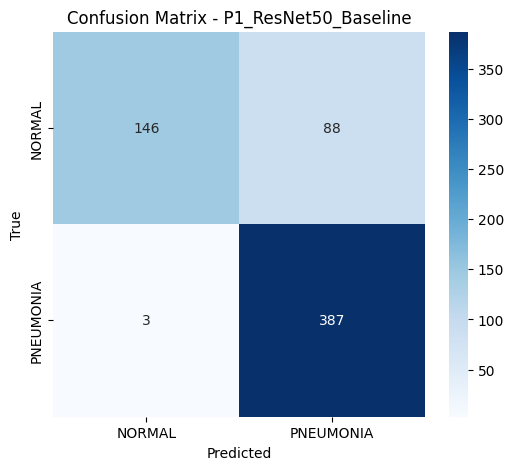


--- Đang đánh giá: P2_EffNetB0_Baseline ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.65      0.77       234
   PNEUMONIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



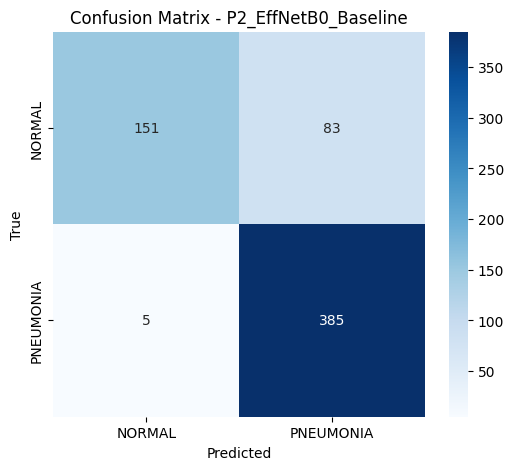


--- Đang đánh giá: P3_ResNet50_Attention_Concat ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.61      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



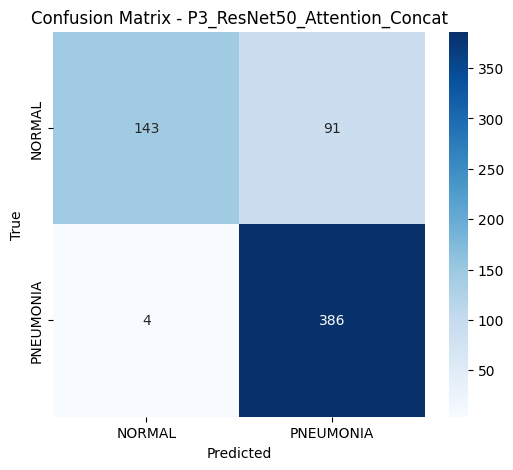


--- Đang đánh giá: P4_EffNetB0_Attention_Concat ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 702ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.66      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



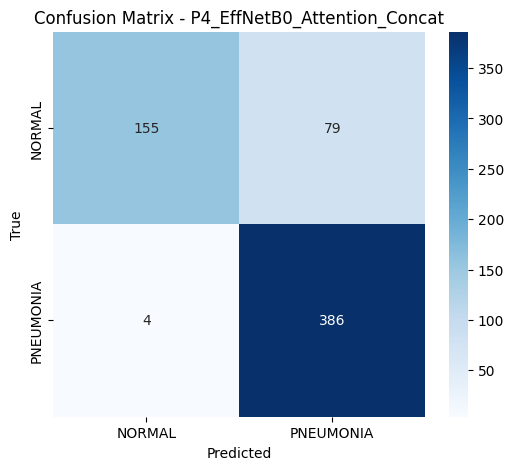


--- HOÀN TẤT ĐÁNH GIÁ ---


In [8]:
# %%
# =======================================================
# CELL 8: EVALUATION FUNCTION (Module hóa)
# (ĐÃ CẬP NHẬT: Trả về dict chứa y_true, y_pred, y_prob
#  để phục vụ Grad-CAM và ROC)
# =======================================================

def run_evaluation(model_name, model_path, test_generator):
    print(f"\n--- Đang đánh giá: {model_name} ---")
    
    # 1. Tải model
    try:
        model = models.load_model(model_path)
    except Exception as e:
        print(f"LỖI: Không thể tải model '{model_path}'. Bỏ qua... Lỗi: {e}")
        return None, None

    # 2. Lấy nhãn thật (y_true)
    y_true = test_generator.get_true_labels()
    
    # 3. Dự đoán (y_prob)
    y_prob = model.predict(test_generator)
    
    # 4. Xử lý nhãn
    y_prob = y_prob[:len(y_true)]
    y_pred = (y_prob > 0.5).astype(int).flatten()
    y_prob_flat = y_prob.flatten()

    # 5. Tính toán metrics
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_true, y_prob_flat)
    }
    
    print(classification_report(y_true, y_pred, target_names=Config.CLASS_NAMES, zero_division=0))
    
    # 6. Vẽ Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=Config.CLASS_NAMES, yticklabels=Config.CLASS_NAMES)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # TỐI ƯU: Trả về dict
    eval_data = {"y_true": y_true, "y_pred": y_pred, "y_prob": y_prob_flat}
    return metrics, eval_data

# --- CHẠY ĐÁNH GIÁ ---
results = {}
eval_data = {} # <-- Đổi tên từ roc_data thành eval_data

# P1
results[Config.P1], eval_data[Config.P1] = run_evaluation(
    Config.P1, all_checkpoints[Config.P1], test_gen_p1
)
# P2
results[Config.P2], eval_data[Config.P2] = run_evaluation(
    Config.P2, all_checkpoints[Config.P2], test_gen_p2
)
# P3
results[Config.P3], eval_data[Config.P3] = run_evaluation(
    Config.P3, all_checkpoints[Config.P3], test_gen_p3
)
# P4
results[Config.P4], eval_data[Config.P4] = run_evaluation(
    Config.P4, all_checkpoints[Config.P4], test_gen_p4
)

print("\n--- HOÀN TẤT ĐÁNH GIÁ ---")

In [9]:
# %%
# =======================================================
# CELL 9: GRAD-CAM UTILITIES
# (Thêm mới)
# =======================================================

def get_gradcam_model(model, last_conv_layer_name):
    """Tạo một model trung gian cho Grad-CAM."""
    try:
        last_conv_layer = model.get_layer(last_conv_layer_name)
    except ValueError:
        print(f"Lỗi: Không tìm thấy layer '{last_conv_layer_name}'")
        print("Đang thử tìm layer lồng nhau (nested)...")
        # Thử tìm trong các model lồng nhau
        # (hữu ích cho P1, P2 nơi feature_extractor là 1 model)
        found = False
        for layer in model.layers:
            if layer.name == last_conv_layer_name:
                last_conv_layer = layer
                found = True
                break
        if not found:
             print(f"Không thể tìm thấy layer '{last_conv_layer_name}'. Grad-CAM sẽ thất bại.")
             return None

    # Model này sẽ lấy input của model gốc
    # và trả về output của last_conv_layer và output của model gốc
    grad_model = Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )
    return grad_model

def make_gradcam_heatmap(
    model_inputs, 
    grad_model, 
    last_conv_layer_output
):
    """Tính toán heatmap."""
    # 1. Tính gradients
    with tf.GradientTape() as tape:
        # Chạy model trung gian
        (conv_outputs, predictions) = grad_model(model_inputs)
        # Lấy class prediction (cho binary)
        loss = predictions[0][0]

    # Lấy gradients của loss w.r.t. conv_outputs
    grads = tape.gradient(loss, conv_outputs)
    
    # 2. Tính toán heatmap
    # Đây là (batch, H, W, C)
    # Lấy gradient trung bình theo kênh
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Nhân channel của conv_outputs với pooled_grads
    conv_outputs = conv_outputs[0] # Bỏ batch dim
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 3. Chuẩn hóa
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def superimpose_gradcam(img_np, heatmap, alpha=0.4):
    """Chồng heatmap lên ảnh gốc."""
    # Resize heatmap về kích thước ảnh
    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Chuyển ảnh gốc về 0-255
    if np.min(img_np) < 0 or np.max(img_np) > 1:
        # Giả sử ảnh đã được preprocess (ví dụ: EffNet)
        img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))
        
    img_bgr = cv2.cvtColor(np.uint8(255 * img_np), cv2.COLOR_RGB2BGR)
    
    superimposed_img = cv2.addWeighted(heatmap, alpha, img_bgr, 1.0, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img

print("Hàm Grad-CAM đã sẵn sàng.")

Hàm Grad-CAM đã sẵn sàng.



--- Grad-CAM cho: P3_ResNet50_Attention_Concat ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


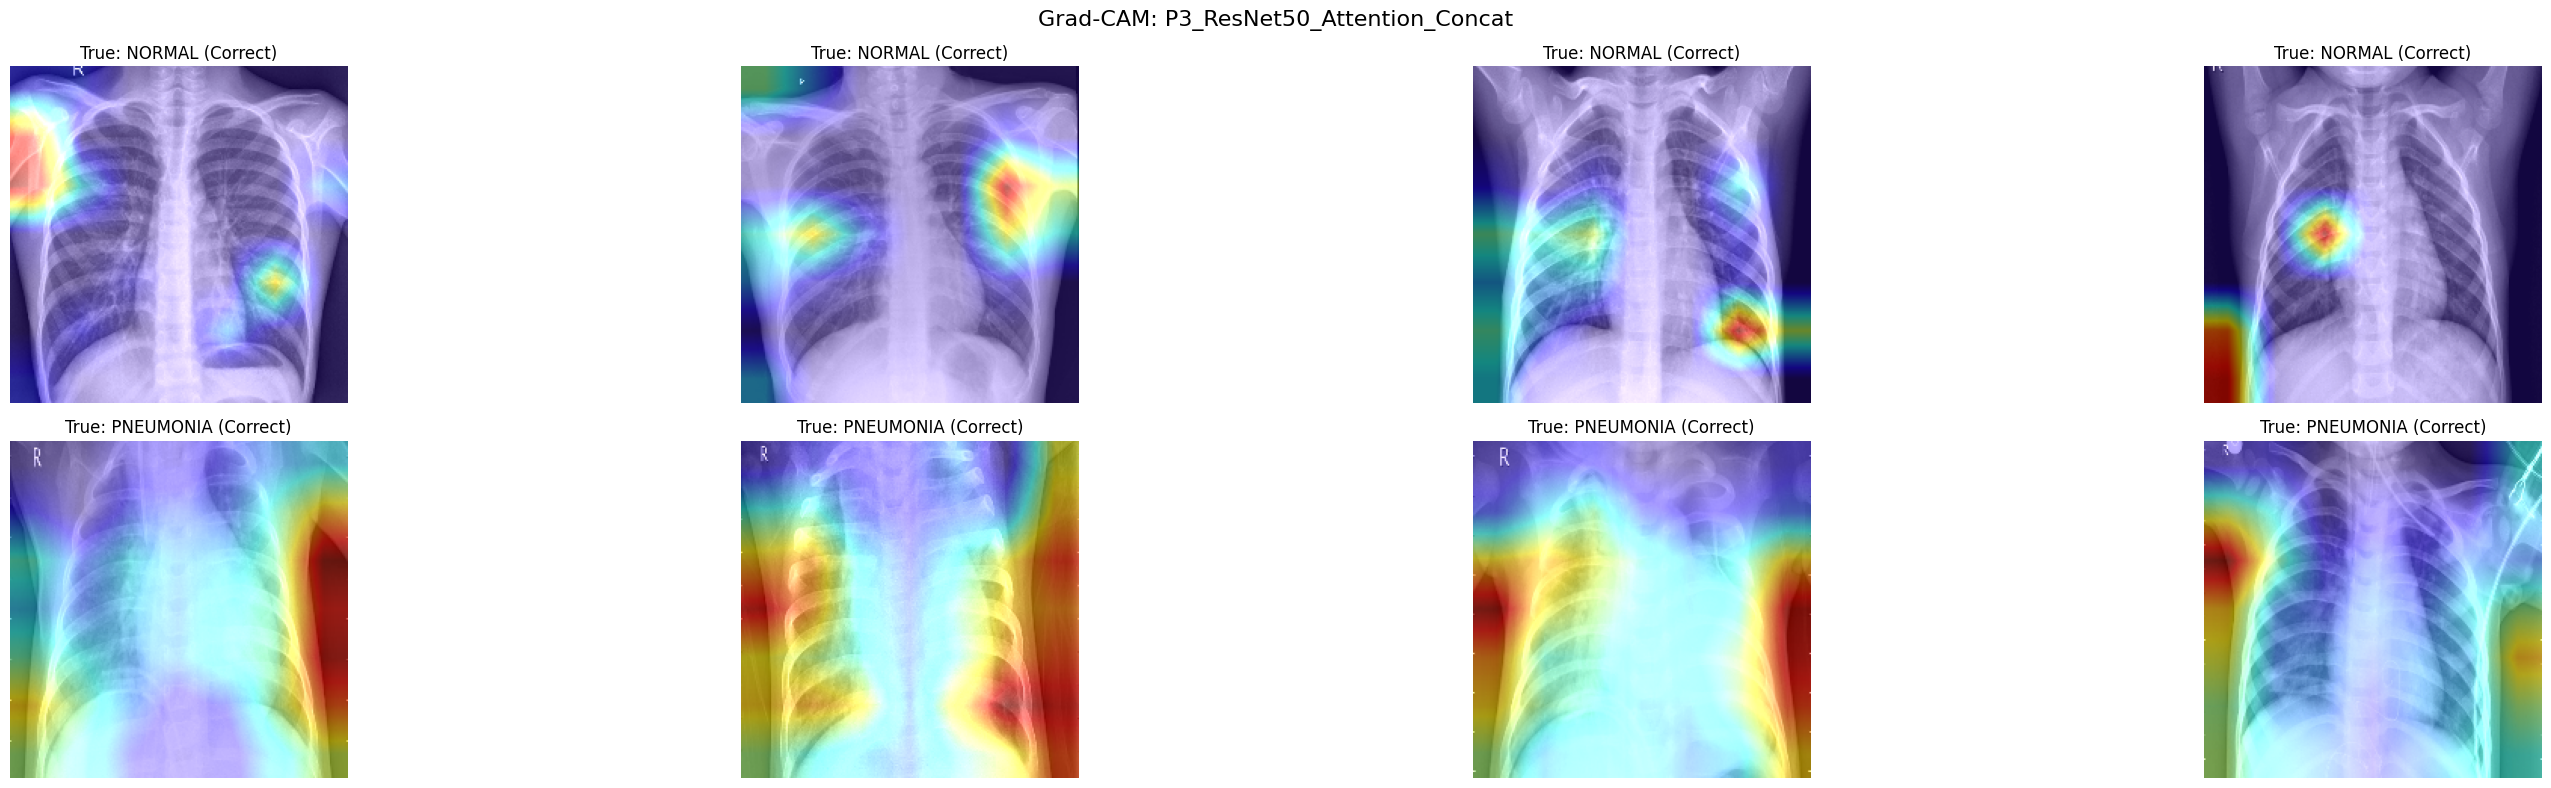


--- Grad-CAM cho: P4_EffNetB0_Attention_Concat ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


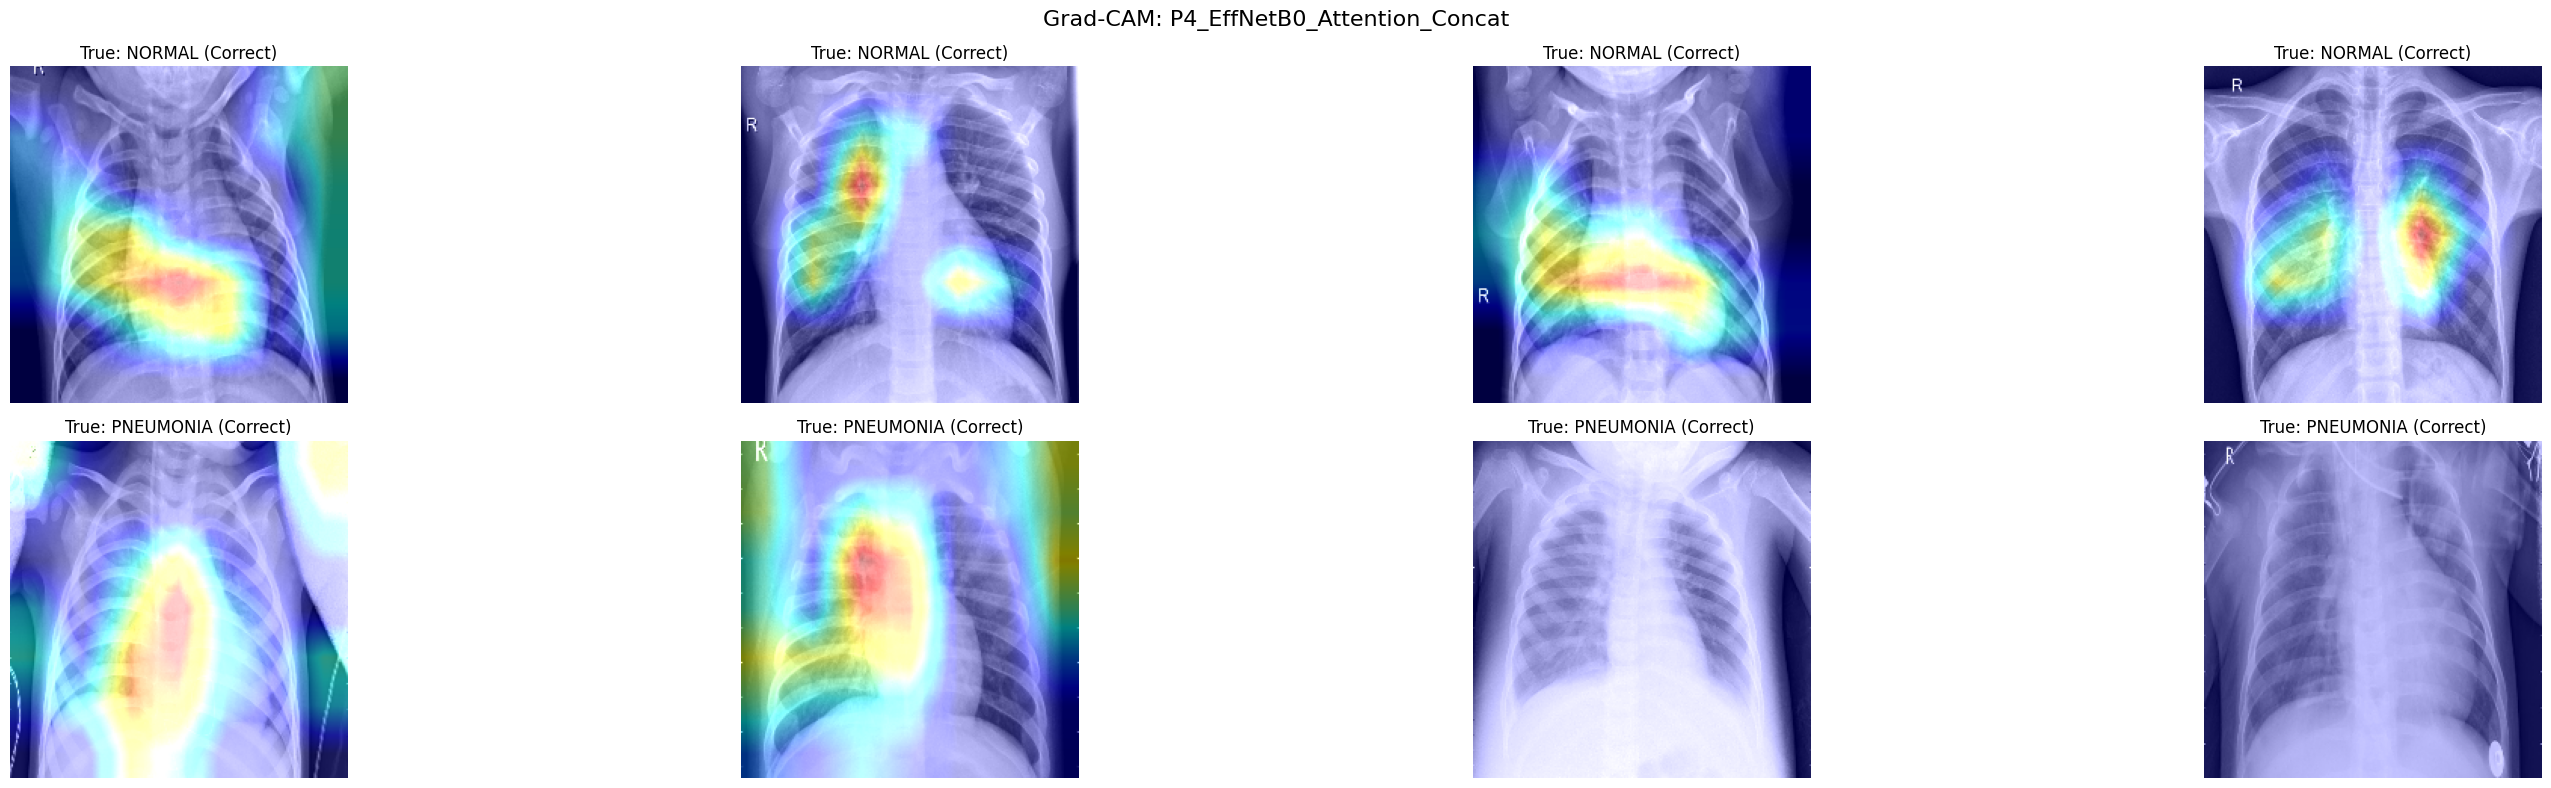

In [10]:
# %%
# =======================================================
# CELL 10: GRAD-CAM VISUALIZATION
# (Thêm mới)
# =======================================================

# 1. Định nghĩa các generator và layer
test_generators = {
    Config.P1: test_gen_p1,
    Config.P2: test_gen_p2,
    Config.P3: test_gen_p3,
    Config.P4: test_gen_p4,
}

# Tên các layer chúng ta đã định nghĩa ở CELL 6
last_conv_layers = {
    Config.P1: 'resnet50_feature_extractor',
    Config.P2: 'efficientnetb0_feature_extractor',
    Config.P3: 'concat_features',
    Config.P4: 'concat_features',
}

# 2. Hàm visualize
def visualize_correct_predictions(
    model_name: str, 
    model_path: str, 
    test_gen: Sequence, 
    conv_layer_name: str,
    eval_results: dict,
    num_images: int = 2
):
    print(f"\n--- Grad-CAM cho: {model_name} ---")
    
    # 1. Tải model và grad_model
    model = models.load_model(model_path)
    grad_model = get_gradcam_model(model, conv_layer_name)
    if grad_model is None:
        print("Không thể tạo Grad-CAM model. Bỏ qua.")
        return

    # 2. Lấy kết quả dự đoán
    y_true = eval_results['y_true']
    y_pred = eval_results['y_pred']

    # 3. Tìm chỉ số (indices) dự đoán đúng
    correct_normal_idx = np.where((y_true == 0) & (y_pred == 0))[0]
    correct_pneumonia_idx = np.where((y_true == 1) & (y_pred == 1))[0]

    if len(correct_normal_idx) == 0 or len(correct_pneumonia_idx) == 0:
        print("Không tìm thấy đủ ảnh dự đoán đúng cho cả 2 class.")
        return

    # Lấy ngẫu nhiên 'num_images'
    selected_normal = np.random.choice(correct_normal_idx, num_images, replace=False)
    selected_pneumonia = np.random.choice(correct_pneumonia_idx, num_images, replace=False)
    selected_indices = np.concatenate([selected_normal, selected_pneumonia])

    # 4. Vẽ
    plt.figure(figsize=(num_images * 8, 8))
    
    for i, idx in enumerate(selected_indices):
        # Lấy batch chứa ảnh
        batch_index = idx // test_gen.batch_size
        item_index = idx % test_gen.batch_size
        X_batch, y_batch = test_gen[batch_index]

        true_label = Config.CLASS_NAMES[y_batch[item_index]]
        
        # Lấy dữ liệu 1 ảnh
        if test_gen.mode == 'baseline':
            img_tensor = X_batch[item_index]
            model_inputs = np.expand_dims(img_tensor, axis=0)
        else: # 'attention'
            img_tensor = X_batch['image_input'][item_index]
            mask_tensor = X_batch['mask_input'][item_index]
            model_inputs = {
                'image_input': np.expand_dims(img_tensor, axis=0),
                'mask_input': np.expand_dims(mask_tensor, axis=0)
            }
        
        # Lấy output của last_conv_layer từ grad_model
        (conv_outputs, _) = grad_model.predict(model_inputs)
        
        # Tạo heatmap
        heatmap = make_gradcam_heatmap(model_inputs, grad_model, conv_outputs)
        
        # Lấy ảnh gốc (đã preprocess) để visualize
        # Chúng ta cần de-process ảnh này để hiển thị
        original_img_to_show = img_tensor
        
        # Chồng ảnh
        superimposed_img = superimpose_gradcam(original_img_to_show, heatmap, alpha=0.5)

        # Vẽ ảnh
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(superimposed_img)
        plt.title(f"True: {true_label} (Correct)")
        plt.axis('off')
        
    plt.suptitle(f'Grad-CAM: {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


# --- CHẠY VISUALIZATION ---
for model_name in [Config.P3, Config.P4]:
    if model_name in all_checkpoints and model_name in eval_data:
        visualize_correct_predictions(
            model_name,
            all_checkpoints[model_name],
            test_generators[model_name],
            last_conv_layers[model_name],
            eval_data[model_name],
            num_images=4 # Lấy 4 ảnh cho mỗi class
        )



--- BẢNG TỔNG HỢP KẾT QUẢ TRÊN TẬP TEST ---


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
P1_ResNet50_Baseline,0.8542,0.8147,0.9923,0.8948,0.9687
P2_EffNetB0_Baseline,0.8590,0.8226,0.9872,0.8974,0.9658
P3_ResNet50_Attention_Concat,0.8478,0.8092,0.9897,0.8904,0.9601
P4_EffNetB0_Attention_Concat,0.8670,0.8301,0.9897,0.9029,0.9710



Đã lưu kết quả vào file 'pipeline_comparison_results_final.csv'


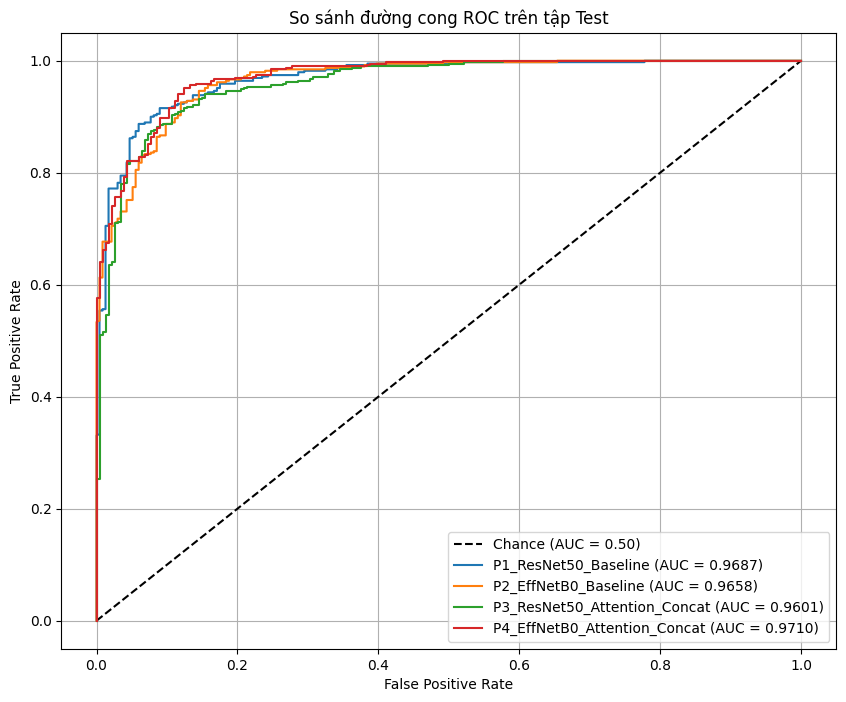

In [11]:
# %%
# =======================================================
# CELL 11: RESULTS SUMMARY & VISUALIZATION
# (Cập nhật từ Cell 9 cũ, sửa 'roc_data' thành 'eval_data')
# =======================================================

print("\n\n--- BẢNG TỔNG HỢP KẾT QUẢ TRÊN TẬP TEST ---")

# Lọc các kết quả None (nếu có lỗi)
valid_results = {k: v for k, v in results.items() if v is not None}

if valid_results:
    results_df = pd.DataFrame(valid_results).T
    results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]

    # Hiển thị bảng với highlight
    styled_df = results_df.style.background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score', 'AUC-ROC']) \
                                .background_gradient(cmap='Blues', subset=['Precision']) \
                                .background_gradient(cmap='Reds', subset=['Recall']) \
                                .format("{:.4f}")
    
    display(styled_df)

    # Lưu ra file
    results_df.to_csv('pipeline_comparison_results_final.csv')
    print("\nĐã lưu kết quả vào file 'pipeline_comparison_results_final.csv'")
else:
    print("Không có kết quả nào để hiển thị.")

# --- Vẽ ROC Curve tổng hợp ---
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

# CẬP NHẬT: Dùng eval_data
for model_name, data in eval_data.items():
    if data:
        # Lấy đúng key từ dict
        y_true = data['y_true']
        y_prob = data['y_prob']
        
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        
        # Lấy AUC từ bảng results (đã tính ở Cell 8)
        if model_name in results and results[model_name]:
            auc_score = results[model_name]['AUC-ROC']
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('So sánh đường cong ROC trên tập Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()